# ¿Cuál es la mejor tarifa?


Megaline es un operador de telecomunicaciones que ofrece a sus clientes dos tarifas de prepago: Surf y Ultimate. Este proyecto tiene por objetivo proporcionar información al departamento comercial sobre cuál de las tarifas genera más ingresos para poder ajustar su presupuesto de publicidad.

Los datos proporcionados por la empresa incluyen información de 500 clientes como: nombre de los clientes, ciudad donde residen, tarifa que usan y su actividad en 2018 (cantidad de llamadas, mensajes de texto y MB utilizados). 

Con esta información se realizará un análisis de las tarifas, mediante el comportamiento de los clientes, con el fin de determinar cuál de las dos tarifas genera mayores ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mt
import matplotlib.pyplot as plt


## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df_users = pd.read_csv('/datasets/megaline_users.csv')
df_calls = pd.read_csv('/datasets/megaline_calls.csv')
df_messages = pd.read_csv('/datasets/megaline_messages.csv')
df_internet = pd.read_csv('/datasets/megaline_internet.csv')
df_plans = pd.read_csv('/datasets/megaline_plans.csv')


## Preparar los datos

Previo al análisis, se explora cada dataframe por separado para tener una noción inicial de los datos, detectar valores ausentes o tipos de datos incorrectos y aplicar las correcciones necesarias.

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
print(df_plans)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


df_plans tiene los tipos de datos adecuados para cada columna y no hay valores ausentes con los que lidiar. Si existieran valores ausentes en este dataframe, lo más apropiado sería preguntar directamente al departamento comercial. Se puede agregar otra columna de gb_per_month_included, para convertir mb a gb y facilitar el análisis más adelante.

## Enriquecer los datos

Se agrega una columna adicional 'gb_per_month_included' para redondear mb a gb

In [5]:
df_plans['gb_per_month_included'] =(df_plans['mb_per_month_included']/1000).astype('int64')
print(df_plans)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  \
0               20          10             0.03            0.03      surf   
1               70           7             0.01            0.01  ultimate   

   gb_per_month_included  
0                     15  
1                     30  


## Usuarios/as

In [6]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
# Imprime una muestra de datos para usuarios
print(df_users.head(5))

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

     reg_date      plan churn_date  
0  2018-12-24  ultimate        NaN  
1  2018-08-13      surf        NaN  
2  2018-10-21      surf        NaN  
3  2018-01-28      surf        NaN  
4  2018-05-23      surf        NaN  


Los tipos de dato en df_users son todos correctos, a excepción de 'user_id', que sería más conveniente ser string (object).
La única columna con valores nulos es churn_date, se sabe que los valores ausentes en esta columna indican que la tarifa se estaba usando cuando fue extraída la base de datos, por lo que no respresentará ninguna afectación al análisis. Sin embargo, los valores nulos se pueden reemplazar con un NA. 

También, para facilitar el futuro análisis respecto al consumo en ciertas ciudades, se puede agregar una columna de tipo booleano que indique si el cliente es del área de Nueva York-Nueva Jersey.

### Corregir los datos

Con base en las observaciones iniciales, se modifica el tipo de dato de la columna 'user_id' y se reemplazan los valores nulos de 'churn_date' con 'NA'

In [8]:
df_users['user_id'] = df_users['user_id'].astype('object')

In [9]:
df_users['churn_date'] = df_users['churn_date'].fillna('NA')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    object
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  500 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.4+ KB


### Enriquecer los datos

Se agrega una columna extra para identificar aquellos clientes que son de Nueva York-Nueva Jersey y así facilitar el futuro análisis respecto al consumo en esta área en comparación con el resto.

In [10]:
df_users['NY_NJ_area'] = df_users['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA'
print(df_users.tail())

    user_id first_name   last_name  age  \
495    1495      Fidel      Sharpe   67   
496    1496      Ariel    Shepherd   49   
497    1497      Donte     Barrera   49   
498    1498       Scot  Williamson   51   
499    1499      Shena     Dickson   37   

                                          city    reg_date      plan  \
495  New York-Newark-Jersey City, NY-NJ-PA MSA  2018-09-04      surf   
496               New Orleans-Metairie, LA MSA  2018-02-20      surf   
497     Los Angeles-Long Beach-Anaheim, CA MSA  2018-12-10  ultimate   
498  New York-Newark-Jersey City, NY-NJ-PA MSA  2018-02-04      surf   
499          Orlando-Kissimmee-Sanford, FL MSA  2018-05-06      surf   

    churn_date  NY_NJ_area  
495         NA        True  
496         NA       False  
497         NA       False  
498         NA        True  
499         NA       False  


## Llamadas

In [11]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [12]:
# Imprime una muestra de datos para las llamadas
print(df_calls.head())

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22


No existen datos ausentes en ninguna columna de 'df_calls'. En cuanto a los tipos de datos, sería conveniente convertir 'user_id' a object y 'call_date' a datetime, con este último cambio es posible agregar una columna para extraer el mes de llamada. A su vez, sería conveniente redondear la duración de la llamada ('duration') al minuto siguiente próximo, esto por la condición de las tarifas. 

### Corregir los datos

Se modifica el tipo de dato de 'user_id' de entero a objeto, y 'call_date' a tipo datetime. Y se redondean los segundos de las llamadas.

In [13]:
df_calls['call_date']= pd.to_datetime(df_calls['call_date'])
df_calls['user_id'] = df_calls['user_id'].astype('object')

In [14]:
df_calls['duration'] = df_calls['duration'].apply(np.ceil).astype('int64')
print(df_calls.head())
df_calls.info()

         id user_id  call_date  duration
0   1000_93    1000 2018-12-27         9
1  1000_145    1000 2018-12-27        14
2  1000_247    1000 2018-12-27        15
3  1000_309    1000 2018-12-28         6
4  1000_380    1000 2018-12-30         5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  object        
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.2+ MB


### Enriquecer los datos

Se agrega una nueva columna con el número de mes de la llamada y de esta manera facilitar el futuro análisis.

In [15]:
df_calls['month_number'] = (df_calls['call_date'].dt.month).astype('object')
print(df_calls.head())

         id user_id  call_date  duration month_number
0   1000_93    1000 2018-12-27         9           12
1  1000_145    1000 2018-12-27        14           12
2  1000_247    1000 2018-12-27        15           12
3  1000_309    1000 2018-12-28         6           12
4  1000_380    1000 2018-12-30         5           12


## Mensajes

In [16]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [17]:
# Imprime una muestra de datos para los mensajes
print(df_messages.head())

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


No existen datos ausentes en 'df_messages'. Al igual que con el dataset de llamadas, el tipo de dato de 'user_id' se puede reemplazar por 'object' y el de 'message_date' por datetime, para de la misma manera crear una nueva columna con el mes para facilitar el análisis.

### Corregir los datos

Con base en las observaciones, se modifica el tipo de dato de 'user_id' de entero a objeto, y 'message_date' a tipo datetime

In [18]:
df_messages['user_id'] = df_messages['user_id'].astype('object')
df_messages['message_date']= pd.to_datetime(df_messages['message_date'])
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  object        
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


### Enriquecer los datos

Se agrega una nueva columna con el número de mes en que se enviaron los mensajes.

In [19]:
df_messages['month_number'] = (df_messages['message_date'].dt.month).astype('object')
print(df_messages.head())

         id user_id message_date month_number
0  1000_125    1000   2018-12-27           12
1  1000_160    1000   2018-12-31           12
2  1000_223    1000   2018-12-31           12
3  1000_251    1000   2018-12-27           12
4  1000_255    1000   2018-12-26           12


## Internet

In [20]:
# Imprime la información general/resumida sobre el DataFrame de internet
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [21]:
# Imprime una muestra de datos para el tráfico de internet
print(df_internet.head())

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


Todos los datos están completos en 'df_internet'. El tipo de dato de 'user_id' se puede cambiar a 'object' para que todos los ids sean strings, y el tipo de dato de 'session_date' se puede modificar a datetime para extraer el número de mes y crear una nueva columna con esta información.

### Corregir los datos

Se modifican los tipos de dato de 'user_id' y 'session_date'

In [22]:
df_internet['user_id'] = df_internet['user_id'].astype('object')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  object        
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.2+ MB


### Enriquecer los datos

Se extrae el mes de la sesión y se crea una nueva columna para manejar los datos más adelante en el proyecto.

In [23]:
df_internet['month_number'] = (df_internet['session_date'].dt.month).astype('object')
print(df_internet.head())

         id user_id session_date  mb_used month_number
0   1000_13    1000   2018-12-29    89.86           12
1  1000_204    1000   2018-12-31     0.00           12
2  1000_379    1000   2018-12-28   660.40           12
3  1000_413    1000   2018-12-26   270.99           12
4  1000_442    1000   2018-12-27   880.22           12


## Estudiar las condiciones de las tarifas

Megaline redondea los segundos a minutos y los megabytes a gigabytes. Para las llamadas, cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto. Para el tráfico web, las sesiones web individuales no se redondean. En su lugar, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes.

In [24]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
print(df_plans)


   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  \
0               20          10             0.03            0.03      surf   
1               70           7             0.01            0.01  ultimate   

   gb_per_month_included  
0                     15  
1                     30  


## Agregar datos por usuario

Ahora que los datos están limpios, se agregan algunos datos por usuario y por periodo para que solo haya un registro por usuario y por periodo, lo que facilitará el análisis posterior.
También se calcularán las ganancias por usuario por mes.

In [25]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls_per_user_count = df_calls.groupby(['user_id', 'month_number'])['id'].count().reset_index(name='call_count')

print(calls_per_user_count)


      user_id  month_number  call_count
0        1000            12          16
1        1001             8          27
2        1001             9          49
3        1001            10          65
4        1001            11          64
...       ...           ...         ...
2253     1498            12          39
2254     1499             9          41
2255     1499            10          53
2256     1499            11          45
2257     1499            12          65

[2258 rows x 3 columns]


In [26]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutes_per_user_sum = df_calls.groupby(['user_id', 'month_number'])['duration'].sum().reset_index(name='minutes_sum')

print(minutes_per_user_sum)


      user_id  month_number  minutes_sum
0        1000            12          124
1        1001             8          182
2        1001             9          315
3        1001            10          393
4        1001            11          426
...       ...           ...          ...
2253     1498            12          339
2254     1499             9          346
2255     1499            10          385
2256     1499            11          308
2257     1499            12          496

[2258 rows x 3 columns]


In [27]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
messages_per_user_count = df_messages.groupby(['user_id', 'month_number'])['id'].count().reset_index(name='message_count')

print(messages_per_user_count)

      user_id  month_number  message_count
0        1000            12             11
1        1001             8             30
2        1001             9             44
3        1001            10             53
4        1001            11             36
...       ...           ...            ...
1801     1496             9             21
1802     1496            10             18
1803     1496            11             13
1804     1496            12             11
1805     1497            12             50

[1806 rows x 3 columns]


In [28]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
mb_per_user_sum = df_internet.groupby(['user_id', 'month_number'])['mb_used'].sum().reset_index(name='mb_sum')


print(mb_per_user_sum)



      user_id  month_number    mb_sum
0        1000            12   1901.47
1        1001             8   6919.15
2        1001             9  13314.82
3        1001            10  22330.49
4        1001            11  18504.30
...       ...           ...       ...
2272     1498            12  23137.69
2273     1499             9  12984.76
2274     1499            10  19492.43
2275     1499            11  16813.83
2276     1499            12  22059.21

[2277 rows x 3 columns]


In [29]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

df_user_monthly_usage = pd.merge(calls_per_user_count, minutes_per_user_sum, on=['user_id','month_number'],how='outer').merge(messages_per_user_count, on=['user_id','month_number'],how='outer').merge(mb_per_user_sum, on=['user_id','month_number'],how='outer')
df_user_monthly_usage.reset_index()

print(df_user_monthly_usage)

      user_id  month_number  call_count  minutes_sum  message_count    mb_sum
0        1000            12        16.0        124.0           11.0   1901.47
1        1001             8        27.0        182.0           30.0   6919.15
2        1001             9        49.0        315.0           44.0  13314.82
3        1001            10        65.0        393.0           53.0  22330.49
4        1001            11        64.0        426.0           36.0  18504.30
...       ...           ...         ...          ...            ...       ...
2288     1349            12         NaN          NaN           61.0  13039.91
2289     1361             5         NaN          NaN            2.0   1519.69
2290     1482            10         NaN          NaN            2.0       NaN
2291     1108            12         NaN          NaN            NaN    233.17
2292     1311             6         NaN          NaN            NaN   1498.83

[2293 rows x 6 columns]


In [30]:
# Añade la información de la tarifa
user_plan= df_users[['user_id','plan']].merge(df_plans, left_on='plan', right_on='plan_name')

df_user_monthly_usage_and_plan = df_user_monthly_usage.merge(user_plan, on='user_id')

print(df_user_monthly_usage_and_plan)

     user_id  month_number  call_count  minutes_sum  message_count    mb_sum  \
0       1000            12        16.0        124.0           11.0   1901.47   
1       1001             8        27.0        182.0           30.0   6919.15   
2       1001             9        49.0        315.0           44.0  13314.82   
3       1001            10        65.0        393.0           53.0  22330.49   
4       1001            11        64.0        426.0           36.0  18504.30   
...      ...           ...         ...          ...            ...       ...   
2288    1204            12         NaN          NaN           78.0  36730.05   
2289    1349            10         NaN          NaN           76.0  13093.55   
2290    1349            11         NaN          NaN           72.0  17128.26   
2291    1349            12         NaN          NaN           61.0  13039.91   
2292    1108            12         NaN          NaN            NaN    233.17   

          plan  messages_included  mb_p

In [80]:
# Calcula el ingreso mensual para cada usuario

df_user_monthly_usage_and_plan['calls_extra_fee'] = np.where(df_user_monthly_usage_and_plan['minutes_sum'] > df_user_monthly_usage_and_plan['minutes_included'],
    (df_user_monthly_usage_and_plan['minutes_sum'] - df_user_monthly_usage_and_plan['minutes_included']) * df_user_monthly_usage_and_plan['usd_per_minute'],
    0)

df_user_monthly_usage_and_plan['messages_extra_fee'] = np.where(df_user_monthly_usage_and_plan['message_count']>df_user_monthly_usage_and_plan['messages_included'],
    (df_user_monthly_usage_and_plan['message_count'] - df_user_monthly_usage_and_plan['messages_included']) * df_user_monthly_usage_and_plan['usd_per_message'],                                                           
    0)

df_user_monthly_usage_and_plan['gb_sum'] = df_user_monthly_usage_and_plan['mb_sum']/1000

df_user_monthly_usage_and_plan['internet_extra_fee'] = np.where(df_user_monthly_usage_and_plan['gb_sum'] > df_user_monthly_usage_and_plan['gb_per_month_included'],
    (df_user_monthly_usage_and_plan['gb_sum'] - df_user_monthly_usage_and_plan['gb_per_month_included']) * df_user_monthly_usage_and_plan['usd_per_gb'],
    0)

df_user_monthly_usage_and_plan['total_earnings'] = df_user_monthly_usage_and_plan['usd_monthly_pay'] + df_user_monthly_usage_and_plan['calls_extra_fee'] + df_user_monthly_usage_and_plan['messages_extra_fee'] + df_user_monthly_usage_and_plan['internet_extra_fee']


monthly_earnings_per_user_monthly = df_user_monthly_usage_and_plan[['user_id','month_number','plan','total_earnings']]
#print(monthly_earnings_per_user_monthly)
monthly_earnings_per_user = monthly_earnings_per_user_monthly.groupby(['user_id','plan'])['total_earnings'].sum().reset_index()
print(monthly_earnings_per_user)

     user_id      plan  total_earnings
0       1000  ultimate         70.0000
1       1001      surf        252.1297
2       1002      surf        103.4508
3       1003      surf        158.5614
4       1004      surf        612.6397
..       ...       ...             ...
485     1495      surf        472.2096
486     1496      surf        128.2826
487     1497  ultimate         70.0000
488     1498      surf        847.1795
489     1499      surf        213.6547

[490 rows x 3 columns]


## Estudia el comportamiento de usuario

Se calculan algunas estadísticas descriptivas para los datos agregados, mostrando un panorama general de la información contenida en los datos. Se utlizan gráficos para facilitar la visualización de los mismos. Se utiliza principalmente un enfoque desde el tipo de plan, para comparar estadísticas de acuerdo con el plan que tienen contratado los usuarios.

### Llamadas

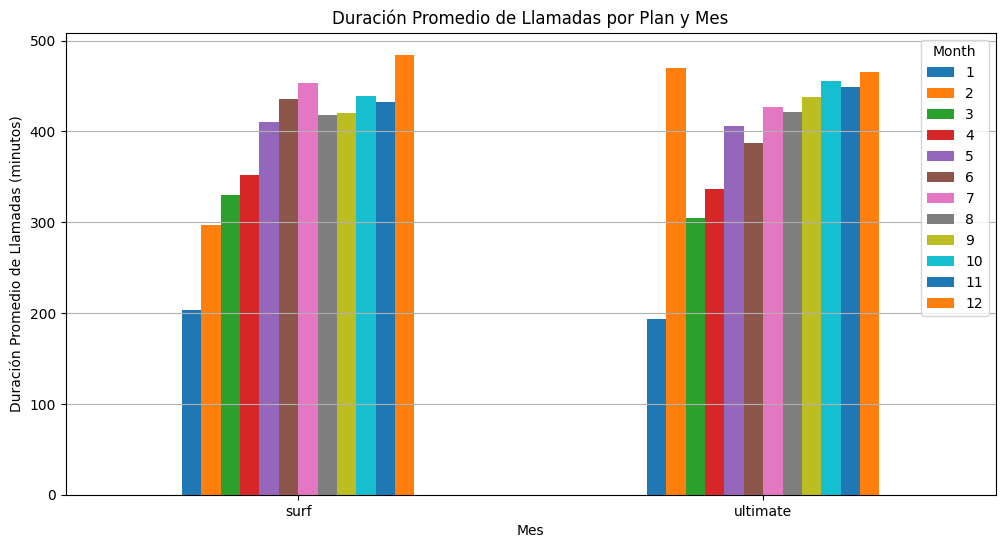

In [32]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
calls_bar = df_user_monthly_usage_and_plan.groupby(['plan','month_number'])['minutes_sum'].mean().unstack()

calls_bar.plot(kind='bar', figsize=(12, 6), title='Duración Promedio de Llamadas por Plan y Mes',xlabel='Mes', ylabel ='Duración Promedio de Llamadas (minutos)', rot =0)
plt.legend(title='Month')
plt.grid(axis='y')
plt.show()

#print(calls_bar)

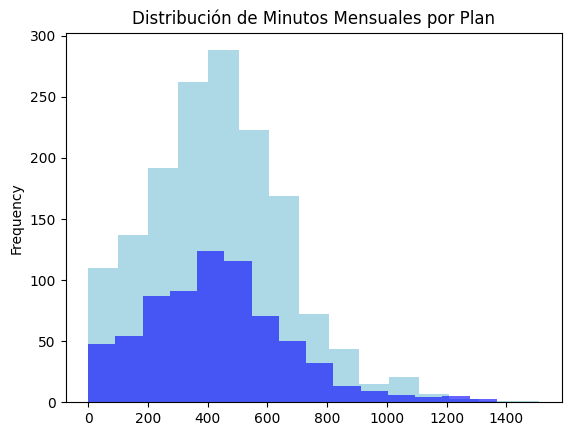

In [33]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
df_user_monthly_usage_and_plan_surf = df_user_monthly_usage_and_plan[df_user_monthly_usage_and_plan['plan']=='surf']
df_user_monthly_usage_and_plan_ultimate = df_user_monthly_usage_and_plan[df_user_monthly_usage_and_plan['plan']=='ultimate']


df_user_monthly_usage_and_plan_surf['minutes_sum'].plot(kind='hist', title='Distribución de Minutos Mensuales por Plan', bins=15, color='lightblue')
df_user_monthly_usage_and_plan_ultimate['minutes_sum'].plot(kind='hist', alpha=0.6, bins=15, color='blue')
#plt.legend(['surf','ultimate'])
plt.xlabel=('Minutos')

plt.show()

In [34]:
# Calcula la media y la varianza de la duración mensual de llamadas.

#surf
print('Surf plan promedio de duración de llamada:', df_user_monthly_usage_and_plan_surf['minutes_sum'].mean())
print('Surf plan varianza de duración de llamada:',np.var(df_user_monthly_usage_and_plan_surf['minutes_sum']))

print()
#ultimate
print('Ultimate plan promedio de duración de llamada:', df_user_monthly_usage_and_plan_ultimate['minutes_sum'].mean())
print('Ultimate plan varianza de duración de llamada:',np.var(df_user_monthly_usage_and_plan_ultimate['minutes_sum']))

Surf plan promedio de duración de llamada: 436.51974110032364
Surf plan varianza de duración de llamada: 52537.03666530514

Ultimate plan promedio de duración de llamada: 434.67601683029454
Ultimate plan varianza de duración de llamada: 56494.28633925359


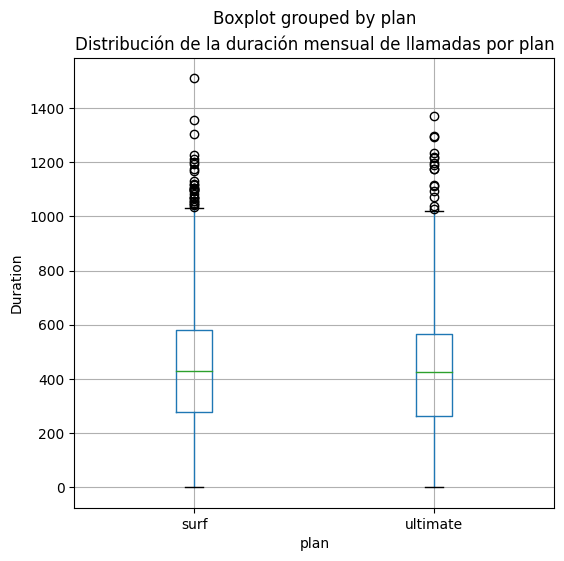

In [35]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
ax = df_user_monthly_usage_and_plan.boxplot(column="minutes_sum", by="plan", figsize=(6,6))
ax.set_ylabel("Duration")
ax.set_title("Distribución de la duración mensual de llamadas por plan")
plt.show()

El comportamiento de los usuarios con respecto a las llamadas es muy similar para ambos planes, de acuerdo con el análisis, el usuario promedio habla por teléfono alrededor de 435 minutos al mes, sin importar qué plan utilice. Además, ambos planes muestran una distribución similar.

### Mensajes

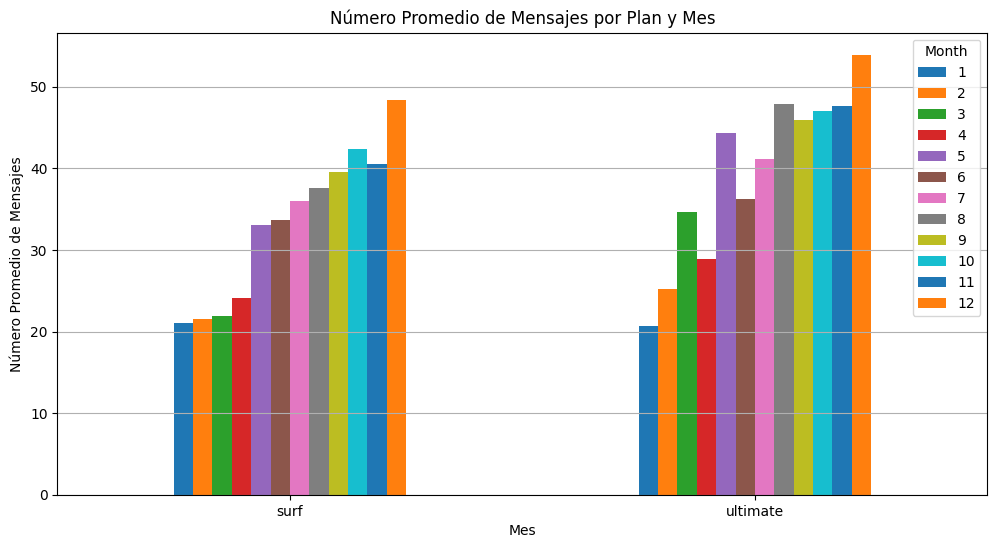

In [36]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
messages_bar = df_user_monthly_usage_and_plan.groupby(['plan','month_number'])['message_count'].mean().unstack()

messages_bar.plot(kind='bar', figsize=(12, 6), title='Número Promedio de Mensajes por Plan y Mes',xlabel='Mes', ylabel ='Número Promedio de Mensajes', rot =0)
plt.legend(title='Month')
plt.grid(axis='y')
plt.show()


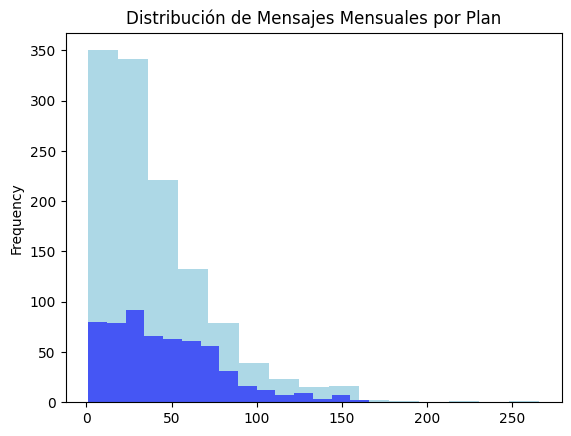

In [37]:
# Compara el número de mensajes mensuales que necesitan los usuarios de cada plan. Traza un histograma.

df_user_monthly_usage_and_plan_surf['message_count'].plot(kind='hist', title='Distribución de Mensajes Mensuales por Plan', bins=15, color='lightblue')
df_user_monthly_usage_and_plan_ultimate['message_count'].plot(kind='hist', alpha=0.6, bins=15, color='blue')
#plt.legend(['surf','ultimate'])
plt.xlabel=('Número de mensajes')

plt.show()



In [38]:
# Media y la varianza de la cantidad mensual de mensajes.

#surf
print('Surf plan promedio de cantidad de mensajes:', df_user_monthly_usage_and_plan_surf['message_count'].mean())
print('Surf plan varianza de cantidad de mensajes:',np.var(df_user_monthly_usage_and_plan_surf['message_count']))

print()
#ultimate
print('Ultimate plan promedio de cantidad de mensajes:', df_user_monthly_usage_and_plan_ultimate['message_count'].mean())
print('Ultimate plan varianza de cantidad de mensajes:',np.var(df_user_monthly_usage_and_plan_ultimate['message_count']))

Surf plan promedio de cantidad de mensajes: 40.10965630114566
Surf plan varianza de cantidad de mensajes: 1090.4511506183685

Ultimate plan promedio de cantidad de mensajes: 46.29623287671233
Ultimate plan varianza de cantidad de mensajes: 1083.3249173156314


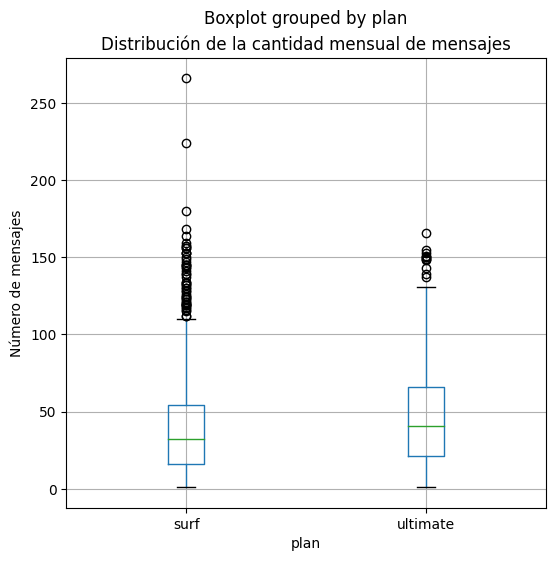

Surf plan
count    1222.000000
mean       40.109656
std        33.035500
min         1.000000
25%        16.000000
50%        32.000000
75%        54.000000
max       266.000000
Name: message_count, dtype: float64

Ultimate plan
count    584.000000
mean      46.296233
std       32.942118
min        1.000000
25%       21.000000
50%       41.000000
75%       66.000000
max      166.000000
Name: message_count, dtype: float64


In [39]:
#Diagrama de caja para visualizar la distribución de la cantidad mensual de mensajes
ax = df_user_monthly_usage_and_plan.boxplot(column="message_count", by="plan", figsize=(6,6))
ax.set_ylabel("Número de mensajes")
ax.set_title("Distribución de la cantidad mensual de mensajes")
plt.show()

print('Surf plan')
print(df_user_monthly_usage_and_plan_surf['message_count'].describe())
print()
print('Ultimate plan')
print(df_user_monthly_usage_and_plan_ultimate['message_count'].describe())

El comportamiento de los usuarios con respecto a los mensajes también resulta ser muy similar para ambos planes, de acuerdo con el análisis anterior, el usuario promedio envía entre 40 y 46 minutos al mes, sin importar qué plan utilice.
La varianza en cuanto al número de mensajes también es similar para ambos planes, sin embargo el plan surf muestra mayor cantidad de valores aislados bastante altos, llegando a un máximo de 266.
Ambos planes muestran una distribución similar.

### Internet

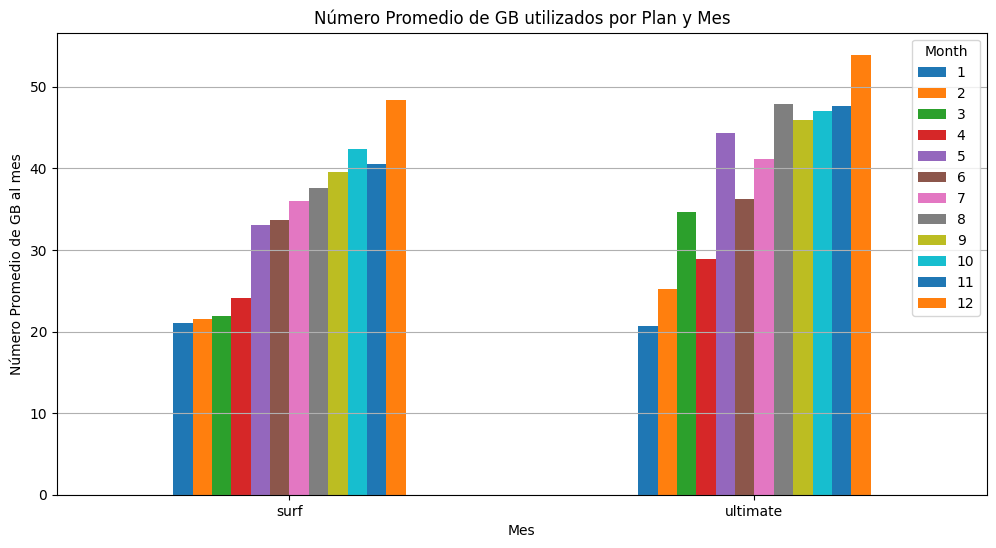

In [40]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
internet_bar = df_user_monthly_usage_and_plan.groupby(['plan','month_number'])['gb_sum'].mean().unstack()

messages_bar.plot(kind='bar', figsize=(12, 6), title='Número Promedio de GB utilizados por Plan y Mes',xlabel='Mes', ylabel ='Número Promedio de GB al mes', rot =0)
plt.legend(title='Month')
plt.grid(axis='y')
plt.show()

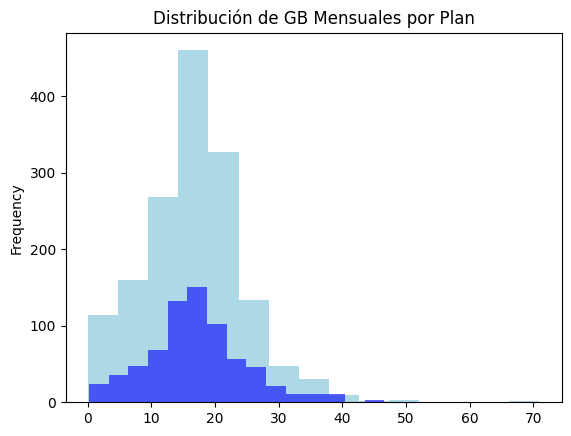

In [41]:
# Comparación del número de GB mensuales que necesitan los usuarios de cada plan e histograma

df_user_monthly_usage_and_plan_surf['gb_sum'].plot(kind='hist', title='Distribución de GB Mensuales por Plan', bins=15, color='lightblue')
df_user_monthly_usage_and_plan_ultimate['gb_sum'].plot(kind='hist', alpha=0.6, bins=15, color='blue')
#plt.legend(['surf','ultimate'])
plt.xlabel=('Número de GB')

plt.show()

In [42]:
# Media y varianza de la cantidad mensual de GB.

#surf
print('Surf plan promedio de cantidad de GB:', df_user_monthly_usage_and_plan_surf['gb_sum'].mean())
print('Surf plan varianza de cantidad de GB:',np.var(df_user_monthly_usage_and_plan_surf['gb_sum']))

print()
#ultimate
print('Ultimate plan promedio de cantidad de GB:', df_user_monthly_usage_and_plan_ultimate['gb_sum'].mean())
print('Ultimate plan varianza de cantidad de GB:',np.var(df_user_monthly_usage_and_plan_ultimate['gb_sum']))

Surf plan promedio de cantidad de GB: 16.717702137355584
Surf plan varianza de cantidad de GB: 62.128323163008716

Ultimate plan promedio de cantidad de GB: 17.23864225312935
Ultimate plan varianza de cantidad de GB: 61.23955612006474


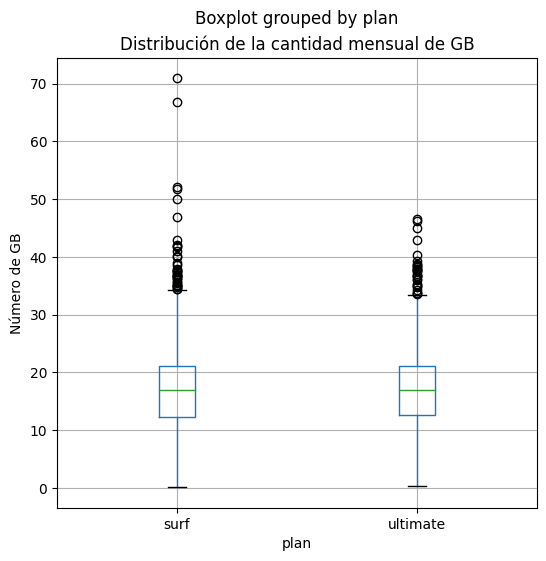

In [43]:
#Diagrama de caja para visualizar la distribución de la cantidad mensual de GB
ax = df_user_monthly_usage_and_plan.boxplot(column="gb_sum", by="plan", figsize=(6,6))
ax.set_ylabel("Número de GB")
ax.set_title("Distribución de la cantidad mensual de GB")
plt.show()



Sorprendentemente, el comportamiento mensual de los usuarios en cuanto al internet, también es bastante similar entre los dos planes; la distribución de ambos planes es similar.
En promedio para ambos planes, el uso es de alrededor de 17 GB. Hasta aquí se puede concluir que el consumo del servicio de internet tampoco varía mucho según el plan, sin embargo, los usuarios del plan 'Surf', que contiene menor cantidad de GB al mes, tienden a excederse más. 

## Ingreso

Del mismo modo, se describe estadísticamente los ingresos de los planes.

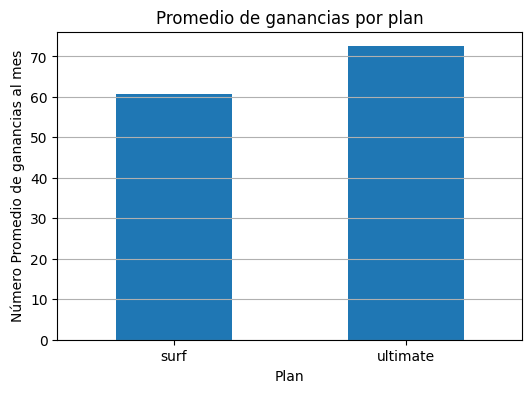

In [44]:
earnings_bar = monthly_earnings_per_user_monthly.groupby('plan')['total_earnings'].mean()

earnings_bar.plot(kind='bar', figsize=(6, 4), title='Promedio de ganancias por plan',xlabel='Plan', ylabel ='Número Promedio de ganancias al mes', rot =0)
plt.grid(axis='y')
plt.show()

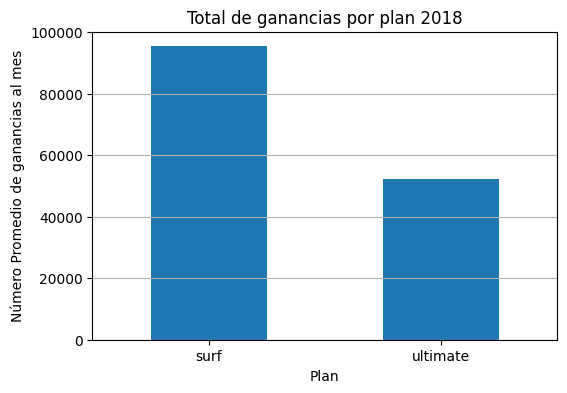

plan
surf        95405.43380
ultimate    52180.48591
Name: total_earnings, dtype: float64


In [45]:
# Total de ingreso anual por plan

earnings_total_bar = monthly_earnings_per_user_monthly.groupby('plan')['total_earnings'].sum()

earnings_total_bar.plot(kind='bar', figsize=(6, 4), title='Total de ganancias por plan 2018',xlabel='Plan', ylabel ='Número Promedio de ganancias al mes', rot =0)
plt.grid(axis='y')
plt.show()

print(monthly_earnings_per_user_monthly.groupby('plan')['total_earnings'].sum())


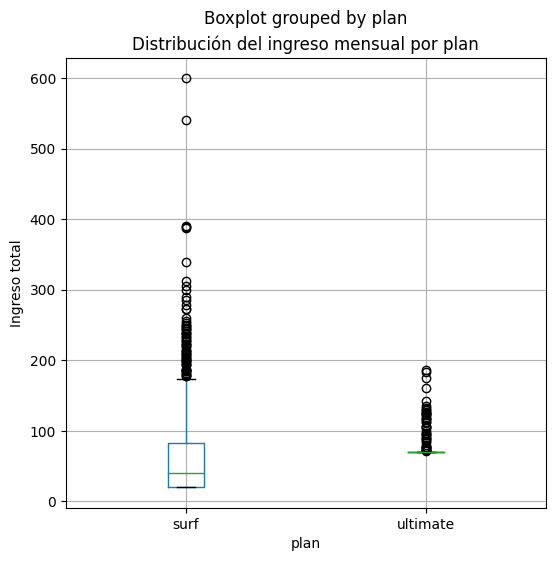

Surf plan
count    1573.000000
mean       60.651897
std        56.140846
min        20.000000
25%        20.000000
50%        40.757600
75%        82.091500
max       599.685900
Name: total_earnings, dtype: float64
Varianza: 3149.7908597549745

Ultimate plan
count    720.000000
mean      72.472897
std       11.981584
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      186.167310
Name: total_earnings, dtype: float64
Varianza: 143.35898019971427


In [46]:
#Diagrama de caja para visualizar la distribución del ingreso mensual para cada plan
ax = monthly_earnings_per_user_monthly.boxplot(column="total_earnings", by="plan", figsize=(6,6))
ax.set_ylabel("Ingreso total")
ax.set_title("Distribución del ingreso mensual por plan")
plt.show()

print('Surf plan')
print(df_user_monthly_usage_and_plan_surf['total_earnings'].describe())
print('Varianza:',np.var(df_user_monthly_usage_and_plan_surf['total_earnings']))
print()
print('Ultimate plan')
print(df_user_monthly_usage_and_plan_ultimate['total_earnings'].describe())
print('Varianza:',np.var(df_user_monthly_usage_and_plan_ultimate['total_earnings']))

Los usuarios del plan 'Surf' tienden a excederse mucho más que los usuarios del plan 'Ultimate'.
El pago mensual del plan 'Surf' es de 20, sin embargo el promedio de ingresos para este plan es de 60: casi lo que cuesta el plan 'Ultimate'. Se puede notar que este exceso está relacionado con los GB utilizados al mes. 
El pago mensual del plan 'Ultimate' es de 70, y los usuarios de este plan en promedio se ajustan a la tarifa.

## Prueba las hipótesis estadísticas

Se prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.


Para esta prueba se obtendrá una muestra de 50 clientes de cada plan. También se establece:

-Hipótesis nula: los ingresos promedio de los dos planes son iguales

-Hipótesis alternativa: los ingresos promedio de los dos planes no son iguales


Para probar esta hipótesis de que las medias de los dos planes son iguales según las muestras tomadas de ellas, se aplicará la función scipy.stats.ttest_ind, estableciendo el parámetro equal_var=False debido a que las varianzas no se consideran iguales.

Se establece un nivel de significancia estadística crítica de alpha = 0.05, con el fin de tener un 95% de confianza en los resultados.


In [78]:
# Establecer las muestras
monthly_earnings_per_user_surf = monthly_earnings_per_user[monthly_earnings_per_user['plan']=='surf']
monthly_earnings_per_user_ultimate = monthly_earnings_per_user[monthly_earnings_per_user['plan']=='ultimate']

#print(monthly_earnings_per_user_surf['user_id'].count())
#print(monthly_earnings_per_user_ultimate['user_id'].count())

np.random.seed(1)
sample_surf = monthly_earnings_per_user_surf['total_earnings'].sample(50)
sample_ultimate = monthly_earnings_per_user_ultimate['total_earnings'].sample(50)


# Prueba las hipótesis
alpha = 0.05  
results = st.ttest_ind(sample_surf, sample_ultimate, equal_var=False)

print('valor p: ', results.pvalue) 

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p:  0.5365859924501291
No podemos rechazar la hipótesis nula


El valor p 0.5365 (utilizando random seed 1) cae en el umbral de no rechazo de la hipótesis nula. Esta probabilidad es claramente demasiado alta para concluir que existe una diferencia significativa entre los ingresos entre ambos paquetes.




A continuación se prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones, obteniendo una muestra de 50 usuarios de cada supuesto.

Para esta prueba se tiene:

Hipótesis nula: el ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones.

Hipótesis alternativa: el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.


Para probar esta hipótesis de que las medias de las dos regiones son iguales según las muestras tomadas de ellas, se aplicará la prueba scipy.stats.ttest_ind, asumiendo que las varianzas son iguales.


Se establece un nivel de significancia estadística crítica de alpha = 0.05, con el fin de tener un 95% de confianza en los resultados.

In [100]:
# Obtener las muestras

monthly_earnings_per_user_2 = monthly_earnings_per_user.merge(df_users, on='user_id', how='left')
monthly_earnings_per_user_city = monthly_earnings_per_user_2[['user_id','total_earnings','plan_x','NY_NJ_area']]

monthly_earnings_per_user_NY_NJ_area = monthly_earnings_per_user_city[monthly_earnings_per_user_city['NY_NJ_area']==True]
monthly_earnings_per_user_NY_NJ_area_false = monthly_earnings_per_user_city[monthly_earnings_per_user_city['NY_NJ_area']==False]

#monthly_earnings_per_user_NY_NJ_area['user_id'].count()
#monthly_earnings_per_user_NY_NJ_area_false['user_id'].count()

np.random.seed(1)
sample_NY_NJ_area = monthly_earnings_per_user_NY_NJ_area['total_earnings'].sample(50)
sample_not_NY_NJ_area = monthly_earnings_per_user_NY_NJ_area_false['total_earnings'].sample(50)

# Prueba las hipótesis
alpha = 0.05  
results = st.ttest_ind(sample_NY_NJ_area, sample_not_NY_NJ_area)

print('valor p: ', results.pvalue) 

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p:  0.17022511725946646
No podemos rechazar la hipótesis nula


El valor p 0.1702 cae en el umbral de no rechazo de la hipótesis nula. Esta probabilidad es lo suficientemente alta para concluir que existe una diferencia significativa entre los ingresos para las diferentes zonas, en otras palabras, no hay diferencia entre los ingresos provenientes de un área a otra.


## Conclusión general

1. Se manejaron los datos de los mensajes, llamadas, y GB de acuerdo a la condición de las tarifas; las llamadas se redondearon al minuto mayor más próximo y los MB se convirtieron a GB al momento del análisis. Se tomó en cuenta el total de GB incluidos en el paquete y el total utilizados por usuario al mes, tanto en la condición de la tarifa como en la tabla de uso de internet. 

2. Se extrajo el número de mes para cada dataframe con la información del uso de llamadas, mensajes e internet para analizarlo por número de mes. Como el análisis es de el año 2018 únicamente, no hay riesgo de tomar en cuenta números de meses repetidos. 

3. Se observó y analizó el comportamiento de los diferentes usuarios por mes (varias ocurrencias de los diferentes ids) por servicio, y no como una única ocurrencia de usuario (anual), para obtener el promedio real del uso mensual de cada servicio. Esto también debido a que hay usuarios que presentaron uso de un cierto servicio únicamente y cero actividad de otro servicio en un mismo mes. 

4. Se calculó el ingreso extra para cada usuario tomando en cuenta el plan contratado de cada uno y añadiendo una tarifa extra por cada servicio que hayan excedido en uso, si no hubo exceso de uso, el ingreso para ese usuario en ese mes sería la tarifa base de su contrato. Se puede analizar de dos maneras: comportamiento mensual y comportamiento total (anual). 

5. El comportamiento mensual resultó más útil para estudiar el comportamiento de usuario en el apartado 1.12

6. En general, el comportamiento de los usuarios respecto a los 3 servicios, no varía según el tipo de plan que tienen contratado. 

7. La prueba estadística elegida para las dos hipótesis se basa en el objetivo de comparar la media de dos muestras diferentes. Debido a que hay una cantidad diferente de usuarios de plan Surf y de plan Ultimate, se seleccionaron muestras de 50 clientes de cada plan, con el fin de estandarizar la prueba. 

8. Se añadió un random_seed(1) a las muestras aleatorias, sin embargo en la ejecución de la prueba se omitió este paso a manera de ensayo y todos los intentos arrojaban la misma conclusión con respecto al valor p contra alpha: el valor p resultaba siempre mayor.

9. Se concluye finalmente que NO se rechaza la hipótesis de que los ingresos promedio de los dos planes son iguales, y tampoco se rechaza la hipótesis de que los ingresos promedio entre las áreas investigadas son iguales.

